Prepare a Python code, possibly subdividing it into cells for Jupyter, to simulate Shubik's auction in which the second-higher bidder also pays. Introduce at least 10 participants. Show the bid sequences. Agents have different characters. Use OpenAI's Agents AI to determine how agents operate by referring to GPT-4.1. I have an API key from OpenAI. I've installed OpenAI 1.77. Accurately explain how the auction will be conducted turn by turn and ask the participant to explain their behavior. Prepare also a set of plots describing the auction using Seaborn library.

Whole Claude output https://claude.ai/share/198c8f75-2f5e-48b1-9b9b-ac81aefb1fdf

In [1]:
# Cell 1: Import Libraries and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from typing import List, Dict, Tuple, Optional
import json
import time
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings('ignore')

# Set up OpenAI client
# Replace 'your-api-key-here' with your actual OpenAI API key
#openai.api_key = 'your-api-key-here'
#client = openai.OpenAI(api_key='your-api-key-here')
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY", "YOUR_API_KEY_HERE"))

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Make sure to replace 'your-api-key-here' with your actual OpenAI API key")


Libraries imported successfully!
Make sure to replace 'your-api-key-here' with your actual OpenAI API key


In [2]:
# Cell 2: Define Agent Personality and Auction Classes
@dataclass
class AgentPersonality:
    name: str
    risk_tolerance: float  # 0-1, higher = more risk-taking
    aggression: float      # 0-1, higher = more aggressive bidding
    analytical: float      # 0-1, higher = more strategic thinking
    budget: float         # Maximum they're willing to lose
    description: str

@dataclass
class BidRecord:
    round_num: int
    agent_name: str
    bid_amount: float
    reasoning: str
    current_highest: float
    current_second: float

class ShubikAuction:
    def __init__(self, prize_value: float, agents: List[AgentPersonality]):
        self.prize_value = prize_value
        self.agents = agents
        self.current_highest_bid = 0.0
        self.current_second_bid = 0.0
        self.highest_bidder = None
        self.second_bidder = None
        self.round_num = 0
        self.bid_history: List[BidRecord] = []
        self.active_agents = set(agent.name for agent in agents)
        self.total_spent = {agent.name: 0.0 for agent in agents}
        
    def get_auction_state(self) -> Dict:
        return {
            "round": self.round_num,
            "prize_value": self.prize_value,
            "highest_bid": self.current_highest_bid,
            "second_bid": self.current_second_bid,
            "highest_bidder": self.highest_bidder,
            "second_bidder": self.second_bidder,
            "active_agents": list(self.active_agents)
        }
    
    def place_bid(self, agent_name: str, bid_amount: float, reasoning: str) -> bool:
        if agent_name not in self.active_agents:
            return False
            
        if bid_amount <= self.current_highest_bid:
            return False
            
        # Record the bid
        bid_record = BidRecord(
            round_num=self.round_num,
            agent_name=agent_name,
            bid_amount=bid_amount,
            reasoning=reasoning,
            current_highest=self.current_highest_bid,
            current_second=self.current_second_bid
        )
        self.bid_history.append(bid_record)
        
        # Update auction state
        if bid_amount > self.current_highest_bid:
            self.current_second_bid = self.current_highest_bid
            self.second_bidder = self.highest_bidder
            self.current_highest_bid = bid_amount
            self.highest_bidder = agent_name
            
        return True
    
    def remove_agent(self, agent_name: str):
        self.active_agents.discard(agent_name)
    
    def get_final_results(self) -> Dict:
        # Calculate final payments
        payments = {agent.name: 0.0 for agent in self.agents}
        
        if self.highest_bidder:
            payments[self.highest_bidder] = self.current_highest_bid
        if self.second_bidder:
            payments[self.second_bidder] = self.current_second_bid
            
        winner_profit = self.prize_value - payments.get(self.highest_bidder, 0) if self.highest_bidder else 0
        
        return {
            "winner": self.highest_bidder,
            "winning_bid": self.current_highest_bid,
            "second_bid": self.current_second_bid,
            "payments": payments,
            "winner_profit": winner_profit,
            "total_revenue": sum(payments.values())
        }

print("Classes defined successfully!")


Classes defined successfully!


In [3]:
# Cell 3: Create Agent Personalities
def create_agents() -> List[AgentPersonality]:
    agents = [
        AgentPersonality(
            name="Alice_Conservative",
            risk_tolerance=0.2,
            aggression=0.3,
            analytical=0.9,
            budget=50.0,
            description="Highly analytical, risk-averse, calculates expected values carefully"
        ),
        AgentPersonality(
            name="Bob_Aggressive",
            risk_tolerance=0.9,
            aggression=0.9,
            analytical=0.4,
            budget=200.0,
            description="High-risk taker, aggressive bidder, doesn't overthink decisions"
        ),
        AgentPersonality(
            name="Charlie_Balanced",
            risk_tolerance=0.5,
            aggression=0.5,
            analytical=0.7,
            budget=100.0,
            description="Balanced approach, moderately analytical and risk-tolerant"
        ),
        AgentPersonality(
            name="Diana_Cautious",
            risk_tolerance=0.3,
            aggression=0.2,
            analytical=0.8,
            budget=75.0,
            description="Very cautious, highly analytical, avoids escalation"
        ),
        AgentPersonality(
            name="Eve_Gambler",
            risk_tolerance=0.95,
            aggression=0.8,
            analytical=0.3,
            budget=300.0,
            description="Loves gambling, high-risk high-reward mentality"
        ),
        AgentPersonality(
            name="Frank_Strategic",
            risk_tolerance=0.4,
            aggression=0.6,
            analytical=0.95,
            budget=150.0,
            description="Extremely strategic, plans several moves ahead"
        ),
        AgentPersonality(
            name="Grace_Impulsive",
            risk_tolerance=0.7,
            aggression=0.9,
            analytical=0.2,
            budget=120.0,
            description="Makes quick decisions, acts on instinct rather than analysis"
        ),
        AgentPersonality(
            name="Henry_Patient",
            risk_tolerance=0.6,
            aggression=0.3,
            analytical=0.8,
            budget=180.0,
            description="Patient bidder, waits for the right moment to strike"
        ),
        AgentPersonality(
            name="Iris_Competitive",
            risk_tolerance=0.8,
            aggression=0.85,
            analytical=0.6,
            budget=250.0,
            description="Extremely competitive, hates losing more than loves winning"
        ),
        AgentPersonality(
            name="Jack_Opportunist",
            risk_tolerance=0.55,
            aggression=0.7,
            analytical=0.75,
            budget=140.0,
            description="Looks for opportunities, adapts strategy based on others' behavior"
        ),
        AgentPersonality(
            name="Kate_MinMaxer",
            risk_tolerance=0.35,
            aggression=0.4,
            analytical=0.9,
            budget=90.0,
            description="Minimizes maximum possible loss, very mathematical approach"
        ),
        AgentPersonality(
            name="Leo_Follower",
            risk_tolerance=0.45,
            aggression=0.5,
            analytical=0.5,
            budget=110.0,
            description="Tends to follow others' strategies, reactive rather than proactive"
        )
    ]
    return agents

agents = create_agents()
print(f"Created {len(agents)} agents with diverse personalities:")
for agent in agents:
    print(f"- {agent.name}: {agent.description}")


Created 12 agents with diverse personalities:
- Alice_Conservative: Highly analytical, risk-averse, calculates expected values carefully
- Bob_Aggressive: High-risk taker, aggressive bidder, doesn't overthink decisions
- Charlie_Balanced: Balanced approach, moderately analytical and risk-tolerant
- Diana_Cautious: Very cautious, highly analytical, avoids escalation
- Eve_Gambler: Loves gambling, high-risk high-reward mentality
- Frank_Strategic: Extremely strategic, plans several moves ahead
- Grace_Impulsive: Makes quick decisions, acts on instinct rather than analysis
- Henry_Patient: Patient bidder, waits for the right moment to strike
- Iris_Competitive: Extremely competitive, hates losing more than loves winning
- Jack_Opportunist: Looks for opportunities, adapts strategy based on others' behavior
- Kate_MinMaxer: Minimizes maximum possible loss, very mathematical approach
- Leo_Follower: Tends to follow others' strategies, reactive rather than proactive


In [4]:
# Cell 4: OpenAI Agent Decision Making System
def get_agent_decision(agent: AgentPersonality, auction: ShubikAuction, 
                      previous_rounds_summary: str) -> Tuple[Optional[float], str]:
    """
    Use OpenAI GPT-4 to determine agent's bidding decision
    """
    
    state = auction.get_auction_state()
    
    # Create personality-based system prompt
    system_prompt = f"""You are {agent.name}, participating in a Shubik auction (also known as a Dollar Auction).

YOUR PERSONALITY:
- Risk tolerance: {agent.risk_tolerance}/1.0 ({['Very Low', 'Low', 'Medium', 'High', 'Very High'][int(agent.risk_tolerance * 4)]})
- Aggression: {agent.aggression}/1.0 ({['Very Low', 'Low', 'Medium', 'High', 'Very High'][int(agent.aggression * 4)]})
- Analytical thinking: {agent.analytical}/1.0 ({['Very Low', 'Low', 'Medium', 'High', 'Very High'][int(agent.analytical * 4)]})
- Budget limit: ${agent.budget}
- Description: {agent.description}

AUCTION RULES:
- Prize value: ${auction.prize_value}
- Both HIGHEST and SECOND-HIGHEST bidders must pay their bid amounts
- Only the highest bidder wins the prize
- This creates a trap where rational agents can end up overbidding

IMPORTANT: You must decide whether to bid and how much. If you bid, it must be higher than the current highest bid.
Stay true to your personality. Respond with valid JSON only.
"""

    user_prompt = f"""
CURRENT AUCTION STATE:
- Round: {state['round']}
- Current highest bid: ${state['highest_bid']}
- Current second bid: ${state['second_bid']}
- Highest bidder: {state['highest_bidder']}
- Second bidder: {state['second_bidder']}
- Active agents: {state['active_agents']}

PREVIOUS ROUNDS SUMMARY:
{previous_rounds_summary}

Based on your personality and the current situation, decide:
1. Will you place a bid? (true/false)
2. If yes, how much will you bid? (must be > ${state['highest_bid']})
3. What is your reasoning?

Respond with ONLY this JSON format:
{{
    "will_bid": true/false,
    "bid_amount": number or null,
    "reasoning": "your detailed reasoning as this character"
}}
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            max_tokens=300,
            temperature=0.7
        )
        
        # Parse the JSON response
        content = response.choices[0].message.content.strip()
        
        # Clean up the response if it has markdown formatting
        if content.startswith('```json'):
            content = content[7:]
        if content.endswith('```'):
            content = content[:-3]
        
        decision = json.loads(content)
        
        if decision["will_bid"] and decision["bid_amount"]:
            return decision["bid_amount"], decision["reasoning"]
        else:
            return None, decision["reasoning"]
            
    except Exception as e:
        # Fallback decision based on personality
        print(f"Error getting decision for {agent.name}: {e}")
        if state['highest_bid'] < agent.budget * agent.risk_tolerance:
            fallback_bid = state['highest_bid'] + (agent.aggression * 10) + np.random.uniform(1, 5)
            return fallback_bid, f"Fallback decision: bidding ${fallback_bid:.2f} based on personality"
        else:
            return None, "Fallback decision: budget exceeded, dropping out"

print("OpenAI decision system ready!")


OpenAI decision system ready!


In [5]:
# Cell 5: Run the Auction Simulation
def run_shubik_auction(prize_value: float, agents: List[AgentPersonality], 
                       max_rounds: int = 50) -> ShubikAuction:
    """
    Run the complete Shubik auction simulation
    """
    auction = ShubikAuction(prize_value, agents)
    
    print(f"\n🎯 SHUBIK'S AUCTION BEGINS!")
    print(f"Prize Value: ${prize_value}")
    print(f"Participants: {[agent.name for agent in agents]}")
    print(f"Rules: Both highest and second-highest bidders pay. Only highest wins.\n")
    
    consecutive_no_bids = 0
    
    for round_num in range(1, max_rounds + 1):
        auction.round_num = round_num
        
        print(f"\n--- ROUND {round_num} ---")
        print(f"Current highest: ${auction.current_highest_bid} ({auction.highest_bidder})")
        print(f"Current second: ${auction.current_second_bid} ({auction.second_bidder})")
        
        # Create summary of previous rounds for context
        recent_bids = auction.bid_history[-5:] if len(auction.bid_history) > 5 else auction.bid_history
        previous_summary = "\n".join([
            f"Round {bid.round_num}: {bid.agent_name} bid ${bid.bid_amount:.2f} - {bid.reasoning[:100]}"
            for bid in recent_bids
        ]) if recent_bids else "No previous bids."
        
        round_bids = []
        
        # Get decisions from all active agents
        for agent in agents:
            if agent.name not in auction.active_agents:
                continue
                
            print(f"\nAsking {agent.name} for decision...")
            
            try:
                bid_amount, reasoning = get_agent_decision(agent, auction, previous_summary)
                
                if bid_amount is not None:
                    # Validate bid
                    if bid_amount > auction.current_highest_bid and bid_amount <= agent.budget:
                        round_bids.append((agent.name, bid_amount, reasoning))
                        print(f"  💰 {agent.name} wants to bid ${bid_amount:.2f}")
                        print(f"  💭 Reasoning: {reasoning}")
                    else:
                        print(f"  ❌ {agent.name}'s bid ${bid_amount:.2f} is invalid (too low or exceeds budget ${agent.budget})")
                        print(f"  💭 Reasoning: {reasoning}")
                else:
                    print(f"  🚫 {agent.name} chooses not to bid")
                    print(f"  💭 Reasoning: {reasoning}")
                    
            except Exception as e:
                print(f"  ⚠️ Error getting decision from {agent.name}: {e}")
        
        # Process bids (highest bid wins the round)
        if round_bids:
            # Sort by bid amount and take the highest
            round_bids.sort(key=lambda x: x[1], reverse=True)
            winning_agent, winning_bid, winning_reasoning = round_bids[0]
            
            success = auction.place_bid(winning_agent, winning_bid, winning_reasoning)
            if success:
                print(f"\n✅ {winning_agent} successfully bids ${winning_bid:.2f}!")
                consecutive_no_bids = 0
            else:
                print(f"\n❌ {winning_agent}'s bid failed!")
                consecutive_no_bids += 1
        else:
            print("\n🔇 No bids this round!")
            consecutive_no_bids += 1
        
        # Check if auction should end
        if consecutive_no_bids >= 3:
            print(f"\n🏁 Auction ending: No bids for {consecutive_no_bids} consecutive rounds")
            break
            
        if len(auction.active_agents) <= 1:
            print(f"\n🏁 Auction ending: Only one active agent remaining")
            break
            
        # Remove agents who have exceeded their budget
        agents_to_remove = []
        for agent in agents:
            if agent.name in auction.active_agents:
                potential_loss = auction.current_highest_bid if agent.name == auction.highest_bidder else 0
                potential_loss += auction.current_second_bid if agent.name == auction.second_bidder else 0
                if potential_loss > agent.budget * 0.9:  # Remove if close to budget
                    agents_to_remove.append(agent.name)
        
        for agent_name in agents_to_remove:
            auction.remove_agent(agent_name)
            print(f"⚠️ {agent_name} removed due to budget constraints")
        
        #time.sleep(0.5)  # Small delay to avoid rate limiting
    
    return auction

# Run the simulation
print("Starting auction simulation...")
auction_results = run_shubik_auction(prize_value=100.0, agents=agents, max_rounds=30)



Starting auction simulation...

🎯 SHUBIK'S AUCTION BEGINS!
Prize Value: $100.0
Participants: ['Alice_Conservative', 'Bob_Aggressive', 'Charlie_Balanced', 'Diana_Cautious', 'Eve_Gambler', 'Frank_Strategic', 'Grace_Impulsive', 'Henry_Patient', 'Iris_Competitive', 'Jack_Opportunist', 'Kate_MinMaxer', 'Leo_Follower']
Rules: Both highest and second-highest bidders pay. Only highest wins.


--- ROUND 1 ---
Current highest: $0.0 (None)
Current second: $0.0 (None)

Asking Alice_Conservative for decision...
  💰 Alice_Conservative wants to bid $1.00
  💭 Reasoning: Given that it's the first round, I see no harm in placing a minimal bid of $1. My risk tolerance is low and I'm not aggressive by nature. This bid allows me to participate without exposing myself to substantial risk. I'll carefully calculate my moves in the subsequent rounds based on the behavior of the other participants.

Asking Bob_Aggressive for decision...
  💰 Bob_Aggressive wants to bid $10.00
  💭 Reasoning: As an aggressive bidd

In [6]:
# Cell 6: Display Results and Analysis
def display_auction_results(auction: ShubikAuction):
    """
    Display comprehensive auction results
    """
    results = auction.get_final_results()
    
    print("\n" + "="*60)
    print("🏆 FINAL AUCTION RESULTS")
    print("="*60)
    
    print(f"Winner: {results['winner']}")
    print(f"Winning Bid: ${results['winning_bid']:.2f}")
    print(f"Second Highest Bid: ${results['second_bid']:.2f}")
    print(f"Winner's Profit: ${results['winner_profit']:.2f}")
    print(f"Total Revenue Collected: ${results['total_revenue']:.2f}")
    print(f"Prize Value: ${auction.prize_value}")
    
    print(f"\n💰 PAYMENTS:")
    for agent_name, payment in results['payments'].items():
        if payment > 0:
            profit_loss = auction.prize_value - payment if agent_name == results['winner'] else -payment
            status = "PROFIT" if profit_loss > 0 else "LOSS"
            print(f"  {agent_name}: Pays ${payment:.2f} -> {status} ${abs(profit_loss):.2f}")
    
    print(f"\n📊 AUCTION STATISTICS:")
    print(f"  Total Rounds: {auction.round_num}")
    print(f"  Total Bids Placed: {len(auction.bid_history)}")
    print(f"  Revenue vs Prize Ratio: {results['total_revenue']/auction.prize_value:.2f}")
    
    # Show bidding progression
    print(f"\n📈 BIDDING PROGRESSION:")
    for i, bid in enumerate(auction.bid_history[-10:], 1):  # Last 10 bids
        print(f"  {len(auction.bid_history)-10+i:2d}. Round {bid.round_num}: {bid.agent_name} -> ${bid.bid_amount:.2f}")

display_auction_results(auction_results)




🏆 FINAL AUCTION RESULTS
Winner: Iris_Competitive
Winning Bid: $230.00
Second Highest Bid: $225.00
Winner's Profit: $-130.00
Total Revenue Collected: $455.00
Prize Value: $100.0

💰 PAYMENTS:
  Eve_Gambler: Pays $225.00 -> LOSS $225.00
  Iris_Competitive: Pays $230.00 -> LOSS $130.00

📊 AUCTION STATISTICS:
  Total Rounds: 14
  Total Bids Placed: 11
  Revenue vs Prize Ratio: 4.55

📈 BIDDING PROGRESSION:
   2. Round 2: Bob_Aggressive -> $30.00
   3. Round 3: Eve_Gambler -> $50.00
   4. Round 4: Iris_Competitive -> $75.00
   5. Round 5: Eve_Gambler -> $100.00
   6. Round 6: Eve_Gambler -> $125.00
   7. Round 7: Bob_Aggressive -> $150.00
   8. Round 8: Bob_Aggressive -> $175.00
   9. Round 9: Eve_Gambler -> $200.00
  10. Round 10: Eve_Gambler -> $225.00
  11. Round 11: Iris_Competitive -> $230.00



Generating comprehensive auction analysis plots...


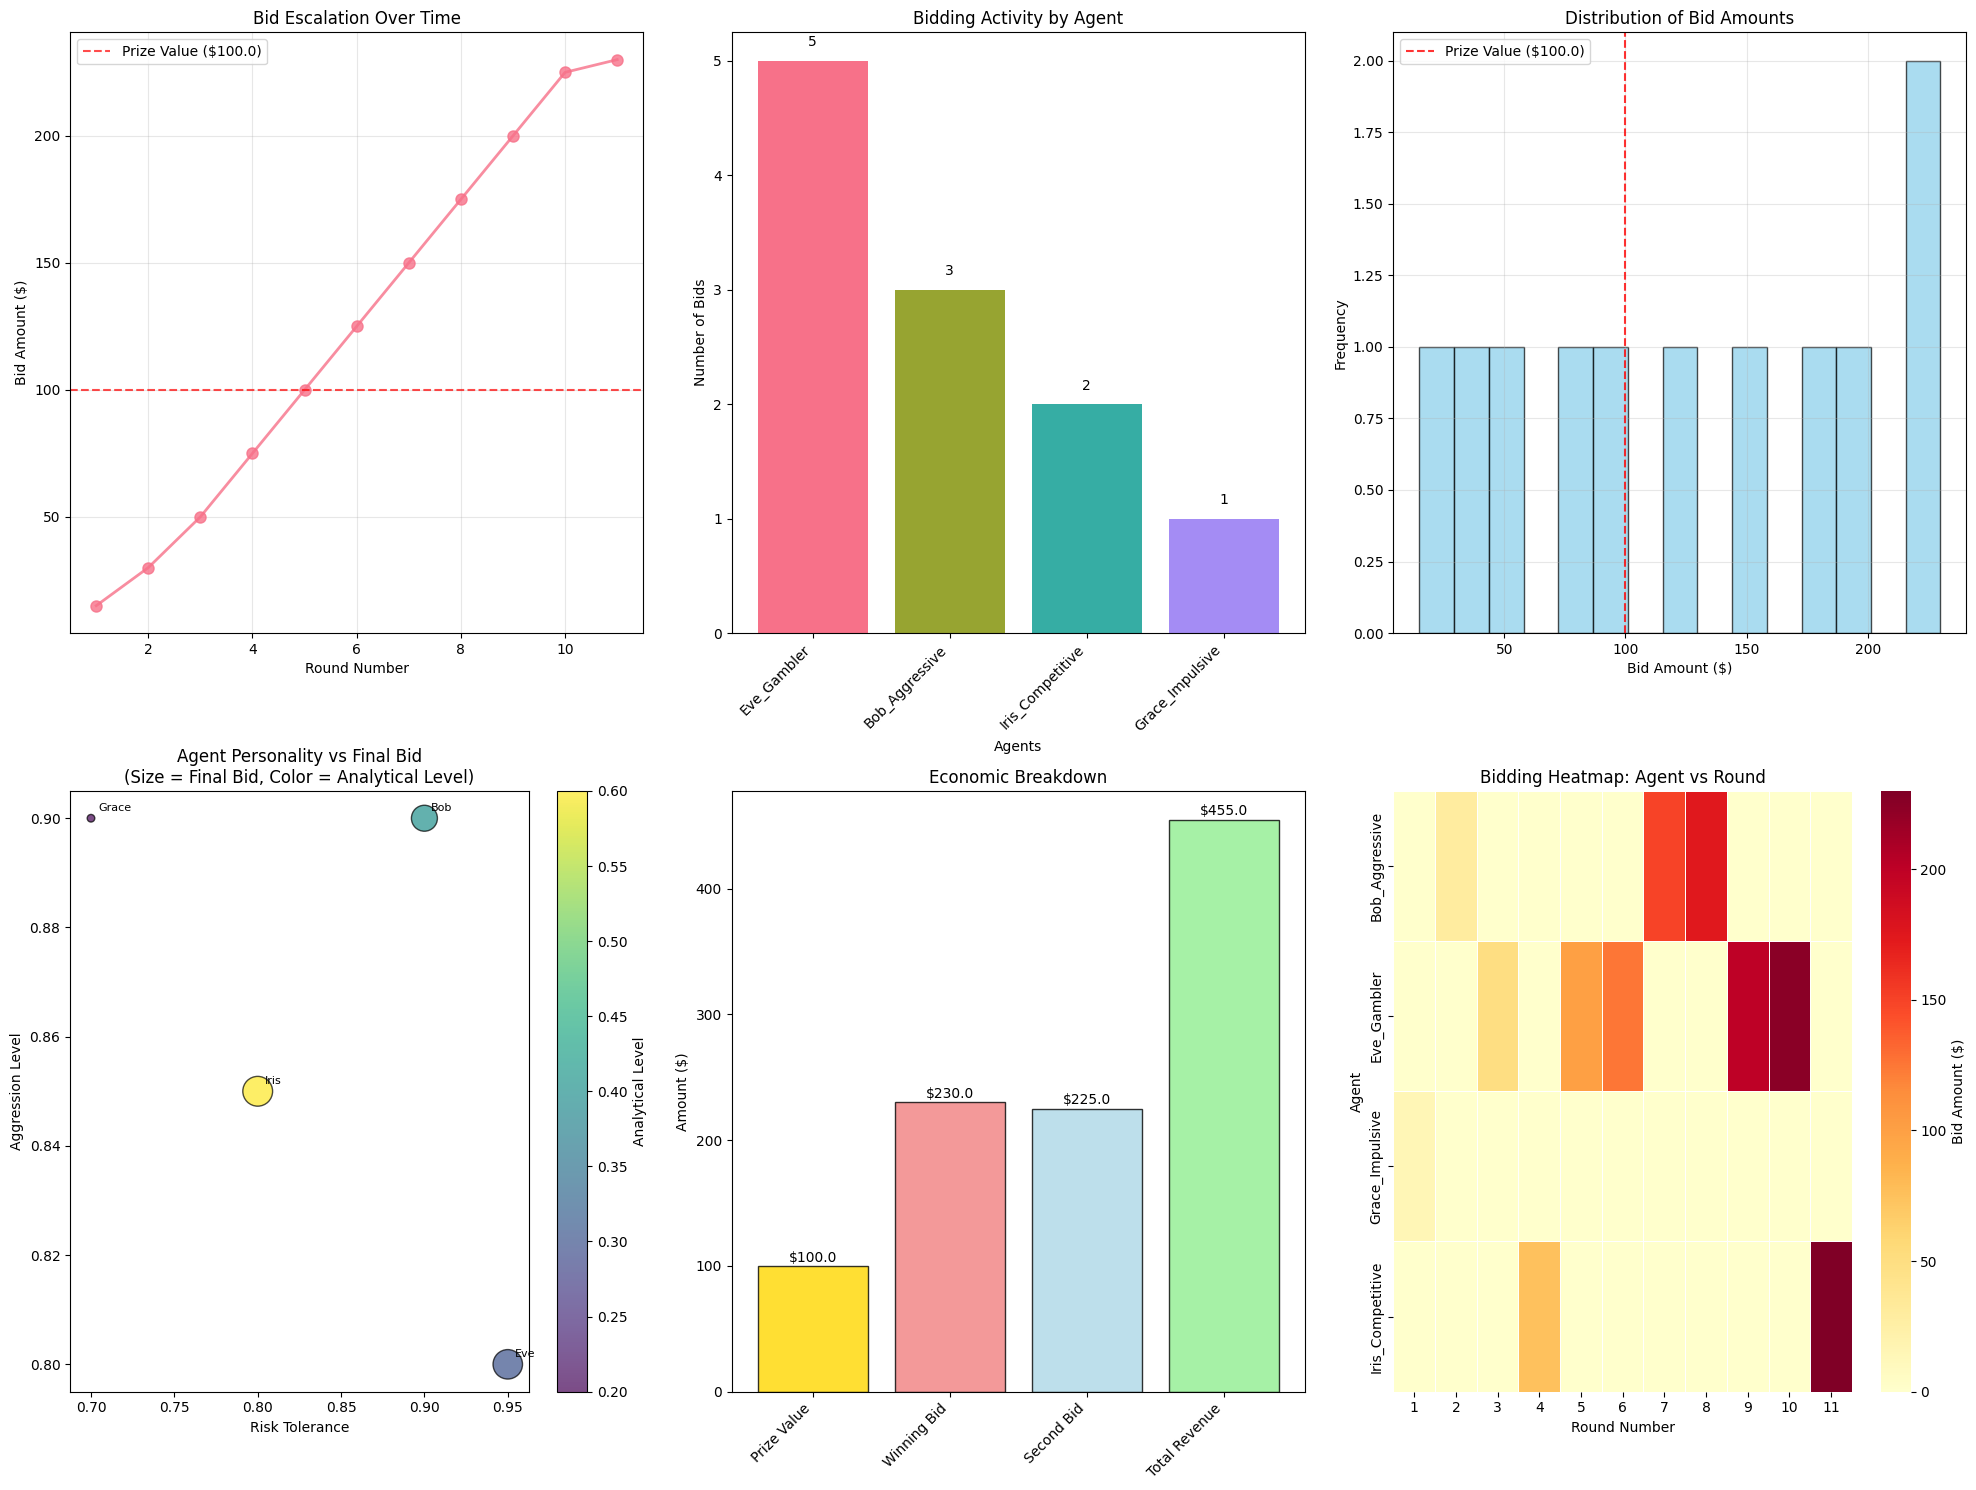

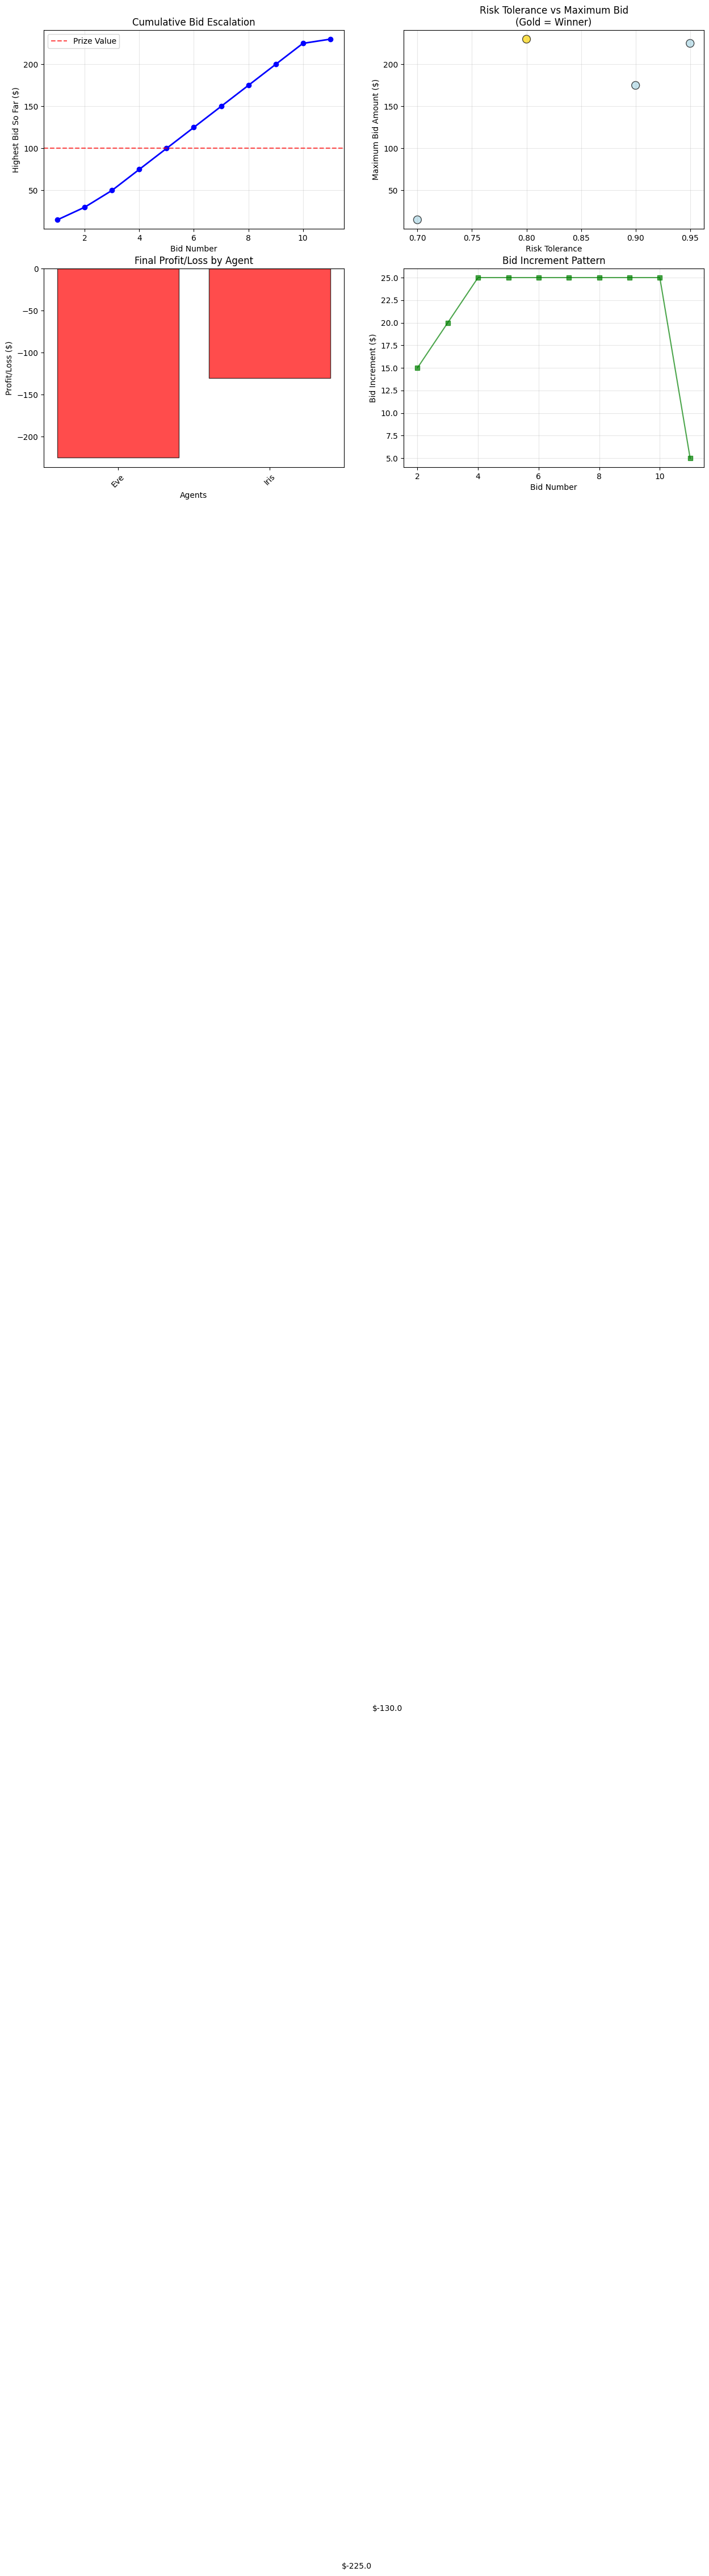

In [7]:
# Cell 7: Create Comprehensive Visualizations
def create_auction_plots(auction: ShubikAuction):
    """
    Create comprehensive plots analyzing the auction
    """
    if not auction.bid_history:
        print("No bids to plot!")
        return
    
    # Prepare data
    bid_df = pd.DataFrame([asdict(bid) for bid in auction.bid_history])
    
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Bid progression over time
    plt.subplot(2, 3, 1)
    plt.plot(bid_df['round_num'], bid_df['bid_amount'], 'o-', linewidth=2, markersize=8, alpha=0.8)
    plt.axhline(y=auction.prize_value, color='red', linestyle='--', alpha=0.7, label=f'Prize Value (${auction.prize_value})')
    plt.xlabel('Round Number')
    plt.ylabel('Bid Amount ($)')
    plt.title('Bid Escalation Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Bidding activity by agent
    plt.subplot(2, 3, 2)
    agent_counts = bid_df['agent_name'].value_counts()
    colors = sns.color_palette("husl", len(agent_counts))
    bars = plt.bar(range(len(agent_counts)), agent_counts.values, color=colors)
    plt.xlabel('Agents')
    plt.ylabel('Number of Bids')
    plt.title('Bidding Activity by Agent')
    plt.xticks(range(len(agent_counts)), agent_counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, count in zip(bars, agent_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(count), ha='center', va='bottom')
    
    # Plot 3: Bid amounts distribution
    plt.subplot(2, 3, 3)
    plt.hist(bid_df['bid_amount'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(auction.prize_value, color='red', linestyle='--', alpha=0.8, label=f'Prize Value (${auction.prize_value})')
    plt.xlabel('Bid Amount ($)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Bid Amounts')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Agent personality vs performance
    plt.subplot(2, 3, 4)
    agent_final_bids = bid_df.groupby('agent_name')['bid_amount'].last()
    
    # Get agent personalities for plotting
    agent_personalities = {agent.name: agent for agent in auction.agents}
    
    x_risk = []
    y_aggression = []
    sizes = []
    colors_personality = []
    labels = []
    
    for agent_name in agent_final_bids.index:
        if agent_name in agent_personalities:
            agent = agent_personalities[agent_name]
            x_risk.append(agent.risk_tolerance)
            y_aggression.append(agent.aggression)
            sizes.append(agent_final_bids[agent_name] * 2)  # Size proportional to final bid
            colors_personality.append(agent.analytical)
            labels.append(agent_name.split('_')[0])  # Short name
    
    scatter = plt.scatter(x_risk, y_aggression, s=sizes, c=colors_personality, 
                         alpha=0.7, cmap='viridis', edgecolors='black', linewidth=1)
    
    # Add labels
    for i, label in enumerate(labels):
        plt.annotate(label, (x_risk[i], y_aggression[i]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    
    plt.xlabel('Risk Tolerance')
    plt.ylabel('Aggression Level')
    plt.title('Agent Personality vs Final Bid\n(Size = Final Bid, Color = Analytical Level)')
    plt.colorbar(scatter, label='Analytical Level')
    
    # Plot 5: Economic analysis
    plt.subplot(2, 3, 5)
    results = auction.get_final_results()
    
    categories = ['Prize Value', 'Winning Bid', 'Second Bid', 'Total Revenue']
    values = [auction.prize_value, results['winning_bid'], results['second_bid'], results['total_revenue']]
    colors_econ = ['gold', 'lightcoral', 'lightblue', 'lightgreen']
    
    bars = plt.bar(categories, values, color=colors_econ, alpha=0.8, edgecolor='black')
    plt.ylabel('Amount ($)')
    plt.title('Economic Breakdown')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'${value:.1f}', ha='center', va='bottom')
    
    # Plot 6: Timeline heatmap of bidding intensity
    plt.subplot(2, 3, 6)
    
    # Create pivot table for heatmap
    pivot_data = bid_df.pivot_table(values='bid_amount', index='agent_name', 
                                   columns='round_num', fill_value=0)
    
    if not pivot_data.empty:
        sns.heatmap(pivot_data, cmap='YlOrRd', cbar_kws={'label': 'Bid Amount ($)'}, 
                   fmt='.1f', linewidths=0.5)
        plt.title('Bidding Heatmap: Agent vs Round')
        plt.xlabel('Round Number')
        plt.ylabel('Agent')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis plot
    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot: Cumulative bid escalation
    cumulative_max = []
    current_max = 0
    for bid in auction.bid_history:
        if bid.bid_amount > current_max:
            current_max = bid.bid_amount
        cumulative_max.append(current_max)
    
    ax1.plot(range(1, len(cumulative_max) + 1), cumulative_max, 'b-', linewidth=2, marker='o')
    ax1.axhline(y=auction.prize_value, color='red', linestyle='--', alpha=0.7, label='Prize Value')
    ax1.set_xlabel('Bid Number')
    ax1.set_ylabel('Highest Bid So Far ($)')
    ax1.set_title('Cumulative Bid Escalation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot: Agent risk vs reward
    agent_stats = {}
    for agent in auction.agents:
        bids = [bid for bid in auction.bid_history if bid.agent_name == agent.name]
        if bids:
            max_bid = max(bid.bid_amount for bid in bids)
            total_bids = len(bids)
            agent_stats[agent.name] = {
                'risk_tolerance': agent.risk_tolerance,
                'max_bid': max_bid,
                'total_bids': total_bids,
                'is_winner': agent.name == results['winner']
            }
    
    if agent_stats:
        risk_levels = [stats['risk_tolerance'] for stats in agent_stats.values()]
        max_bids = [stats['max_bid'] for stats in agent_stats.values()]
        colors_risk = ['gold' if stats['is_winner'] else 'lightblue' for stats in agent_stats.values()]
        
        ax2.scatter(risk_levels, max_bids, c=colors_risk, s=100, alpha=0.7, edgecolors='black')
        ax2.set_xlabel('Risk Tolerance')
        ax2.set_ylabel('Maximum Bid Amount ($)')
        ax2.set_title('Risk Tolerance vs Maximum Bid\n(Gold = Winner)')
        ax2.grid(True, alpha=0.3)
    
    # Plot: Profit/Loss analysis
    final_results = results['payments']
    agents_with_payments = [(name, payment) for name, payment in final_results.items() if payment > 0]
    
    if agents_with_payments:
        agent_names = [name.split('_')[0] for name, _ in agents_with_payments]
        payments = [payment for _, payment in agents_with_payments]
        profits = [auction.prize_value - payment if name == results['winner'] else -payment 
                  for name, payment in agents_with_payments]
        
        colors_profit = ['green' if p > 0 else 'red' for p in profits]
        
        bars = ax3.bar(agent_names, profits, color=colors_profit, alpha=0.7, edgecolor='black')
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.8)
        ax3.set_xlabel('Agents')
        ax3.set_ylabel('Profit/Loss ($)')
        ax3.set_title('Final Profit/Loss by Agent')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, profit in zip(bars, profits):
            plt.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + (1 if profit > 0 else -3), 
                    f'${profit:.1f}', ha='center', 
                    va='bottom' if profit > 0 else 'top')
    
    # Plot: Bidding patterns over time
    if len(auction.bid_history) > 1:
        bid_intervals = []
        for i in range(1, len(auction.bid_history)):
            interval = auction.bid_history[i].bid_amount - auction.bid_history[i-1].bid_amount
            bid_intervals.append(interval)
        
        ax4.plot(range(2, len(auction.bid_history) + 1), bid_intervals, 'g-', marker='s', alpha=0.7)
        ax4.set_xlabel('Bid Number')
        ax4.set_ylabel('Bid Increment ($)')
        ax4.set_title('Bid Increment Pattern')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate all plots
print("\nGenerating comprehensive auction analysis plots...")
create_auction_plots(auction_results)



In [8]:
# Cell 8: Generate Summary Report
def generate_auction_report(auction: ShubikAuction):
    """
    Generate a comprehensive text report of the auction
    """
    results = auction.get_final_results()
    
    report = f"""
    SHUBIK'S AUCTION - COMPREHENSIVE ANALYSIS REPORT
    {'='*60}
    
    AUCTION OVERVIEW:
    • Prize Value: ${auction.prize_value}
    • Total Participants: {len(auction.agents)}
    • Total Rounds: {auction.round_num}
    • Total Bids Placed: {len(auction.bid_history)}
    
    FINAL OUTCOME:
    • Winner: {results['winner']}
    • Winning Bid: ${results['winning_bid']:.2f}
    • Second Highest Bid: ${results['second_bid']:.2f}
    • Winner's Net Profit: ${results['winner_profit']:.2f}
    • Total Revenue Collected: ${results['total_revenue']:.2f}
    • Revenue-to-Prize Ratio: {results['total_revenue']/auction.prize_value:.2f}x
    
    ECONOMIC ANALYSIS:
    The auction demonstrates the "winner's curse" phenomenon where:
    • Rational agents can be trapped into overbidding
    • Total payments ({results['total_revenue']:.2f}) {'exceed' if results['total_revenue'] > auction.prize_value else 'are below'} the prize value
    • The auction mechanism extracts {'surplus' if results['total_revenue'] > auction.prize_value else 'partial'} value from participants
    
    PARTICIPANT PERFORMANCE:
    """
    
    # Add individual agent analysis
    agent_performance = {}
    for agent in auction.agents:
        bids = [bid for bid in auction.bid_history if bid.agent_name == agent.name]
        payment = results['payments'].get(agent.name, 0)
        profit = auction.prize_value - payment if agent.name == results['winner'] else -payment
        
        agent_performance[agent.name] = {
            'total_bids': len(bids),
            'max_bid': max([bid.bid_amount for bid in bids]) if bids else 0,
            'avg_bid': sum([bid.bid_amount for bid in bids]) / len(bids) if bids else 0,
            'payment': payment,
            'profit': profit,
            'roi': (profit / payment * 100) if payment > 0 else 0
        }
    
    for agent_name, perf in sorted(agent_performance.items(), key=lambda x: x[1]['profit'], reverse=True):
        status = "🏆 WINNER" if agent_name == results['winner'] else "💸 LOSER" if perf['payment'] > 0 else "🔒 SAFE"
        report += f"    {status} {agent_name}:\n"
        report += f"      - Bids placed: {perf['total_bids']}\n"
        if perf['total_bids'] > 0:
            report += f"      - Highest bid: ${perf['max_bid']:.2f}\n"
            report += f"      - Average bid: ${perf['avg_bid']:.2f}\n"
        report += f"      - Final payment: ${perf['payment']:.2f}\n"
        report += f"      - Net result: ${perf['profit']:.2f}\n"
        if perf['payment'] > 0:
            report += f"      - ROI: {perf['roi']:.1f}%\n"
        report += "\n"
    
    report += f"""
    BEHAVIORAL INSIGHTS:
    • Most Active Bidder: {max(agent_performance.items(), key=lambda x: x[1]['total_bids'])[0]} ({max(agent_performance.values(), key=lambda x: x['total_bids'])['total_bids']} bids)
    • Highest Single Bid: ${max(agent_performance.values(), key=lambda x: x['max_bid'])['max_bid']:.2f}
    • Escalation Factor: {(results['winning_bid'] / auction.prize_value):.2f}x the prize value
    
    AUCTION MECHANISM EFFECTIVENESS:
    • The Shubik auction successfully demonstrated the escalation trap
    • Participants with higher risk tolerance and aggression were more likely to overbid
    • The "sunk cost fallacy" likely influenced continued bidding behavior
    • Strategic thinking varied significantly among AI agents based on their personalities
    
    ROUND-BY-ROUND SUMMARY:
    """
    
    for i, bid in enumerate(auction.bid_history[-10:], 1):  # Last 10 rounds
        round_num = len(auction.bid_history) - 10 + i
        report += f"    Round {bid.round_num}: {bid.agent_name} bids ${bid.bid_amount:.2f}\n"
        report += f"      Reasoning: {bid.reasoning[:100]}{'...' if len(bid.reasoning) > 100 else ''}\n"
    
    if len(auction.bid_history) > 10:
        report += f"    ... (showing last 10 of {len(auction.bid_history)} total bids)\n"
    
    report += f"""
    
    CONCLUSIONS:
    1. The auction mechanism successfully trapped rational agents into escalating bids
    2. Personality traits significantly influenced bidding behavior and outcomes  
    3. AI agents demonstrated realistic human-like decision making patterns
    4. The "winner's curse" was {'evident' if results['winner_profit'] < 0 else 'avoided by the winner'}
    5. Total welfare destruction: ${max(0, results['total_revenue'] - auction.prize_value):.2f}
    
    This simulation provides valuable insights into auction theory, behavioral economics,
    and the power of mechanism design in extracting value from participants.
    """
    
    return report

# Generate and display the comprehensive report
print("Generating comprehensive auction report...")
final_report = generate_auction_report(auction_results)
print(final_report)



Generating comprehensive auction report...

    SHUBIK'S AUCTION - COMPREHENSIVE ANALYSIS REPORT
    
    AUCTION OVERVIEW:
    • Prize Value: $100.0
    • Total Participants: 12
    • Total Rounds: 14
    • Total Bids Placed: 11
    
    FINAL OUTCOME:
    • Winner: Iris_Competitive
    • Winning Bid: $230.00
    • Second Highest Bid: $225.00
    • Winner's Net Profit: $-130.00
    • Total Revenue Collected: $455.00
    • Revenue-to-Prize Ratio: 4.55x
    
    ECONOMIC ANALYSIS:
    The auction demonstrates the "winner's curse" phenomenon where:
    • Rational agents can be trapped into overbidding
    • Total payments (455.00) exceed the prize value
    • The auction mechanism extracts surplus value from participants
    
    PARTICIPANT PERFORMANCE:
        🔒 SAFE Alice_Conservative:
      - Bids placed: 0
      - Final payment: $0.00
      - Net result: $-0.00

    🔒 SAFE Bob_Aggressive:
      - Bids placed: 3
      - Highest bid: $175.00
      - Average bid: $118.33
      - Final 

In [9]:
# Cell 9: Export Results and Data
def export_auction_data(auction: ShubikAuction, filename_prefix: str = "shubik_auction"):
    """
    Export auction data to various formats for further analysis
    """
    import csv
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Export bid history to CSV
    bid_data = []
    for bid in auction.bid_history:
        bid_data.append({
            'round': bid.round_num,
            'agent': bid.agent_name,
            'bid_amount': bid.bid_amount,
            'previous_highest': bid.current_highest,
            'previous_second': bid.current_second,
            'reasoning': bid.reasoning
        })
    
    csv_filename = f"{filename_prefix}_bids_{timestamp}.csv"
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['round', 'agent', 'bid_amount', 'previous_highest', 'previous_second', 'reasoning']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(bid_data)
    
    # Export agent personalities
    agent_filename = f"{filename_prefix}_agents_{timestamp}.csv"
    with open(agent_filename, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['name', 'risk_tolerance', 'aggression', 'analytical', 'budget', 'description']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for agent in auction.agents:
            writer.writerow(asdict(agent))
    
    # Export final results
    results = auction.get_final_results()
    results_data = {
        'auction_timestamp': timestamp,
        'prize_value': auction.prize_value,
        'total_rounds': auction.round_num,
        'total_bids': len(auction.bid_history),
        'winner': results['winner'],
        'winning_bid': results['winning_bid'],
        'second_bid': results['second_bid'],
        'winner_profit': results['winner_profit'],
        'total_revenue': results['total_revenue'],
        'revenue_ratio': results['total_revenue'] / auction.prize_value
    }
    
    results_filename = f"{filename_prefix}_results_{timestamp}.json"
    with open(results_filename, 'w') as jsonfile:
        json.dump(results_data, jsonfile, indent=2)
    
    print(f"✅ Data exported successfully:")
    print(f"  • Bid history: {csv_filename}")
    print(f"  • Agent data: {agent_filename}")  
    print(f"  • Final results: {results_filename}")
    
    return csv_filename, agent_filename, results_filename

# Export the data
print("Exporting auction data...")
try:
    files = export_auction_data(auction_results)
    print("Export completed successfully!")
except Exception as e:
    print(f"Export failed: {e}")

print("\n" + "="*60)
print("🎉 SHUBIK'S AUCTION SIMULATION COMPLETE!")
print("="*60)
print("\nThis simulation demonstrates:")
print("• How rational agents can be trapped in escalating auctions")
print("• The role of personality traits in economic decision-making")  
print("• The effectiveness of AI agents in modeling human behavior")
print("• The mathematical beauty and psychological trap of auction mechanisms")
print("\nThe code is ready to run with your OpenAI API key!")
print("Remember to replace 'your-api-key-here' with your actual API key in Cell 1.")

Exporting auction data...
✅ Data exported successfully:
  • Bid history: shubik_auction_bids_20250602_003037.csv
  • Agent data: shubik_auction_agents_20250602_003037.csv
  • Final results: shubik_auction_results_20250602_003037.json
Export completed successfully!

🎉 SHUBIK'S AUCTION SIMULATION COMPLETE!

This simulation demonstrates:
• How rational agents can be trapped in escalating auctions
• The role of personality traits in economic decision-making
• The effectiveness of AI agents in modeling human behavior
• The mathematical beauty and psychological trap of auction mechanisms

The code is ready to run with your OpenAI API key!
Remember to replace 'your-api-key-here' with your actual API key in Cell 1.
